In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list al"l files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-detection/sample-submission.csv
/kaggle/input/breast-cancer-detection/train.csv
/kaggle/input/breast-cancer-detection/test.csv


# Install Dependancies

In [5]:
!pip install klib

In [6]:
import klib
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, confusion_matrix
import warnings
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt


# Get Datasets

In [7]:
train = pd.read_csv('/kaggle/input/breast-cancer-detection/train.csv')
test = pd.read_csv('/kaggle/input/breast-cancer-detection/test.csv')
sample = pd.read_csv('/kaggle/input/breast-cancer-detection/sample-submission.csv')
warnings.filterwarnings('ignore')

# Basic EDA

In [8]:
train.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,diagnosis
0,869691,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.07415,0.2678,...,91.93,591.7,0.1385,0.4092,0.45040,0.18650,0.5774,0.10300,NaN,M
1,898677,10.26,14.71,66.20,321.6,0.09882,0.09159,0.03581,0.02037,0.1633,...,70.89,357.1,0.1360,0.1636,0.07162,0.04074,0.2434,0.08488,NaN,B
2,852973,15.30,25.27,102.40,732.4,0.10820,0.16970,0.16830,0.08751,0.1926,...,149.30,1269.0,0.1641,0.6110,0.63350,0.20240,0.4027,0.09876,NaN,M
3,914580,12.47,17.31,80.45,480.1,0.08928,0.07630,0.03609,0.02369,0.1526,...,92.82,607.3,0.1276,0.2506,0.20280,0.10530,0.3035,0.07661,NaN,B
4,886776,15.32,17.27,103.20,713.3,0.13350,0.22840,0.24480,0.12420,0.2398,...,119.80,928.8,0.1765,0.4503,0.44290,0.22290,0.3258,0.11910,NaN,M


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       398 non-null    int64  
 1   radius_mean              398 non-null    float64
 2   texture_mean             398 non-null    float64
 3   perimeter_mean           398 non-null    float64
 4   area_mean                398 non-null    float64
 5   smoothness_mean          398 non-null    float64
 6   compactness_mean         398 non-null    float64
 7   concavity_mean           398 non-null    float64
 8   concave points_mean      398 non-null    float64
 9   symmetry_mean            398 non-null    float64
 10  fractal_dimension_mean   398 non-null    float64
 11  radius_se                398 non-null    float64
 12  texture_se               398 non-null    float64
 13  perimeter_se             398 non-null    float64
 14  area_se                  3

In [10]:
train.isna().sum()

id                           0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                398
diagnosi

# Data Cleaning

In [11]:
train = train.drop(columns=['Unnamed: 32', 'id'])
test = test.drop(columns=['Unnamed: 32', 'id'])
train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,14.183236,19.274171,92.345377,660.460553,0.096540,0.104395,0.090043,0.049586,0.181707,0.062741,...,16.360005,25.607663,107.907688,891.912563,0.132461,0.254167,0.276683,0.116187,0.291139,0.083802
std,3.548961,4.119494,24.438949,351.641745,0.014136,0.051625,0.080718,0.039031,0.027905,0.006929,...,4.901033,5.947946,33.937742,577.586383,0.021980,0.148297,0.209022,0.064881,0.060838,0.016672
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.116700,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.081250,0.034320,0.000000,0.000000,0.156500,0.055040
25%,11.717500,16.345000,75.467500,421.275000,0.086755,0.066712,0.030090,0.020710,0.161925,0.057682,...,13.020000,21.392500,84.430000,516.425000,0.117275,0.147325,0.117125,0.065600,0.252625,0.072310
50%,13.445000,18.895000,86.965000,556.950000,0.095825,0.094740,0.064905,0.033950,0.180050,0.061820,...,15.110000,25.300000,99.165000,700.650000,0.131350,0.217000,0.238900,0.105350,0.282800,0.079960
75%,16.115000,21.695000,106.525000,802.025000,0.106075,0.130500,0.132050,0.074112,0.196550,0.066075,...,19.242500,29.425000,127.100000,1143.500000,0.145900,0.342675,0.386400,0.166075,0.320600,0.092075
max,27.420000,33.810000,186.900000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.095750,...,36.040000,49.540000,251.200000,4254.000000,0.200600,0.932700,1.252000,0.291000,0.577400,0.148600


In [12]:
train['diagnosis'] = (train['diagnosis'] == 'M')

# In Depth EDA

<Axes: title={'center': 'Feature-correlation (pearson)'}>

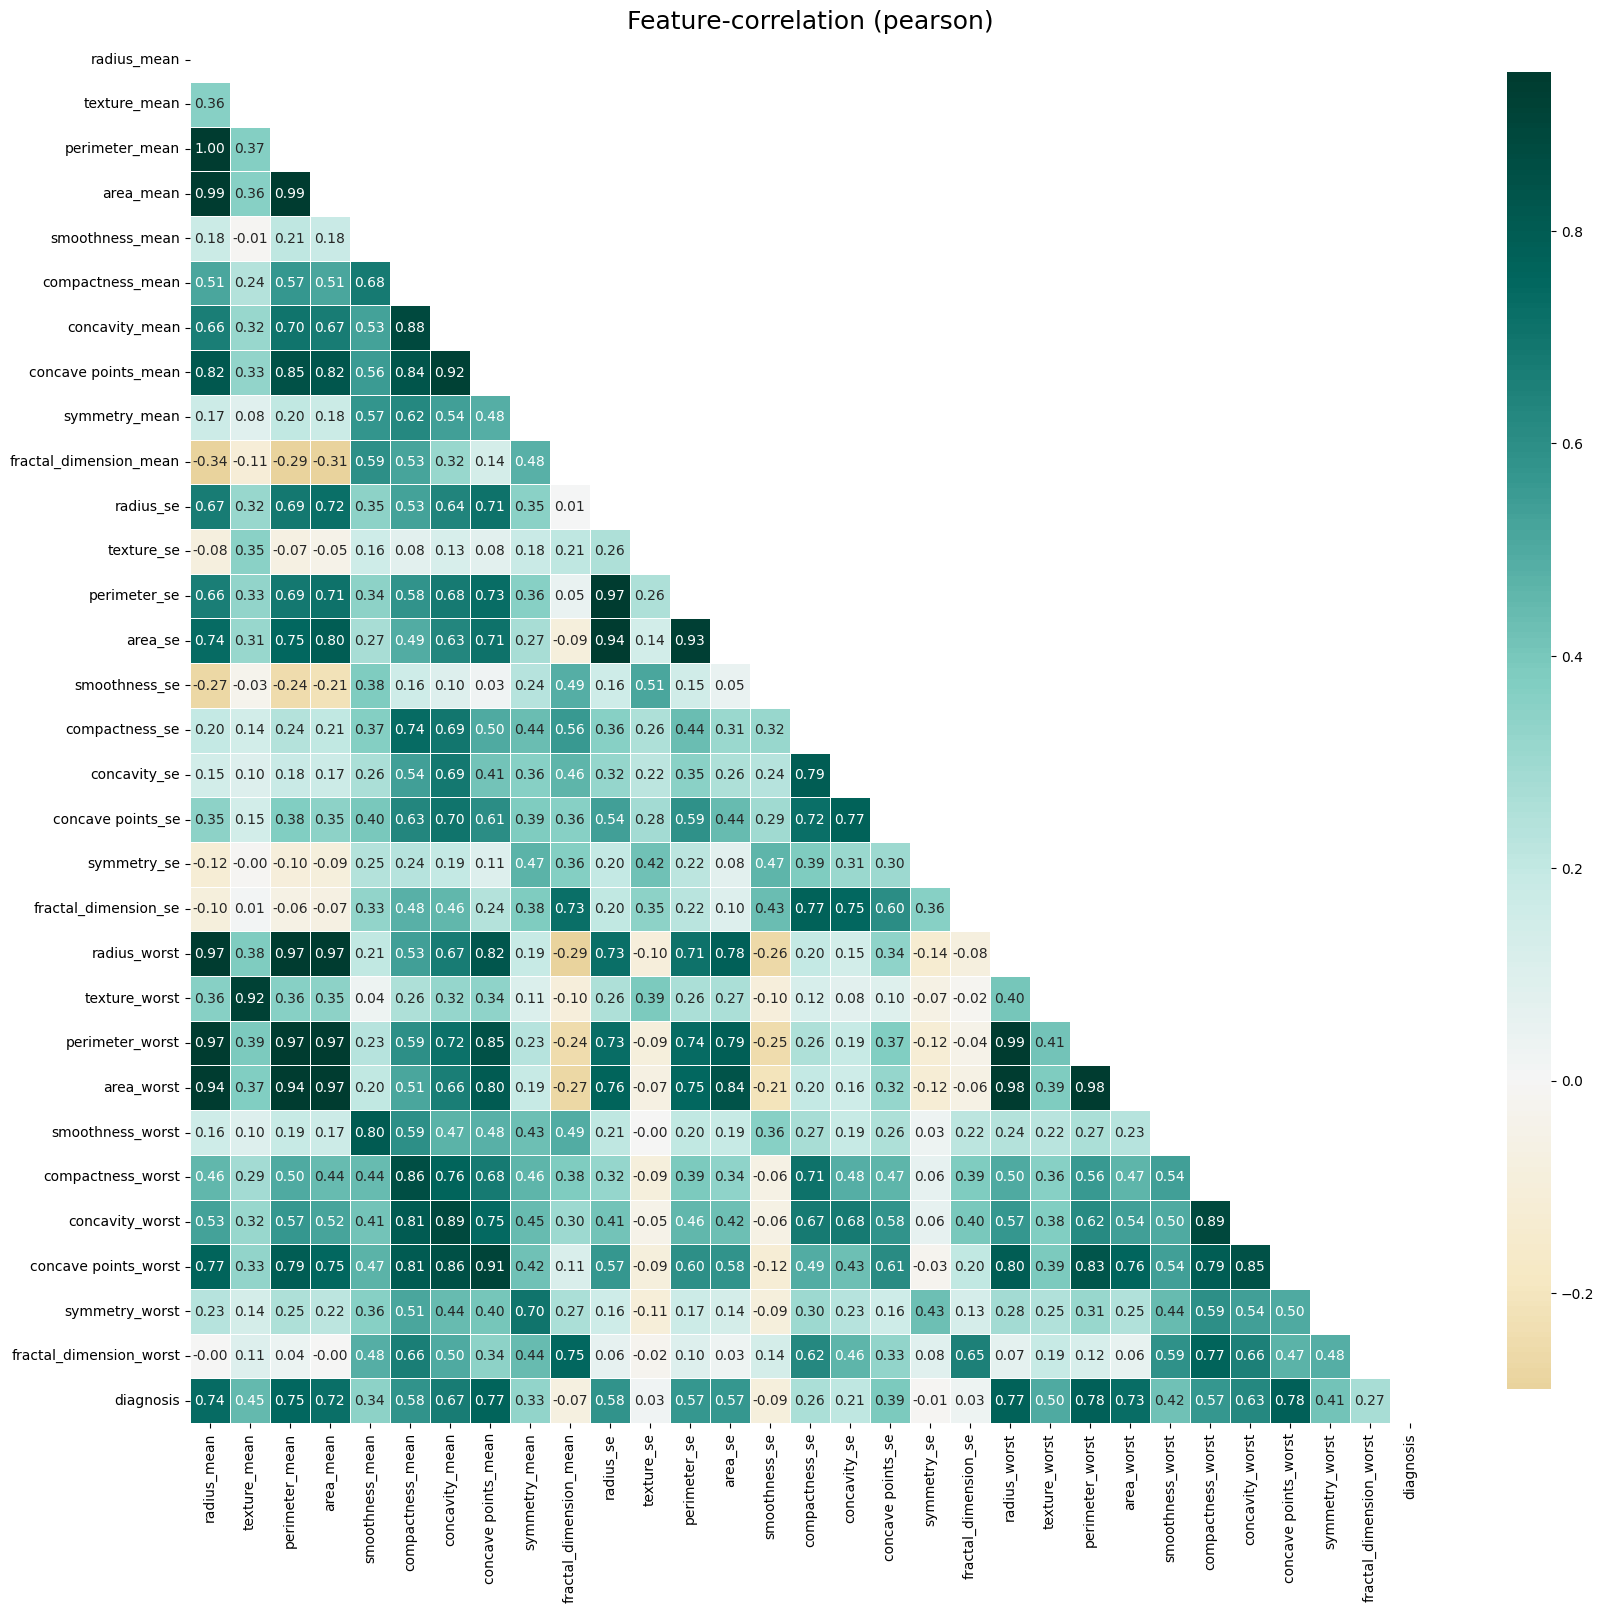

In [13]:
klib.corr_plot(train, figsize=(20,18))

<Axes: xlabel='fractal_dimension_worst', ylabel='Density'>

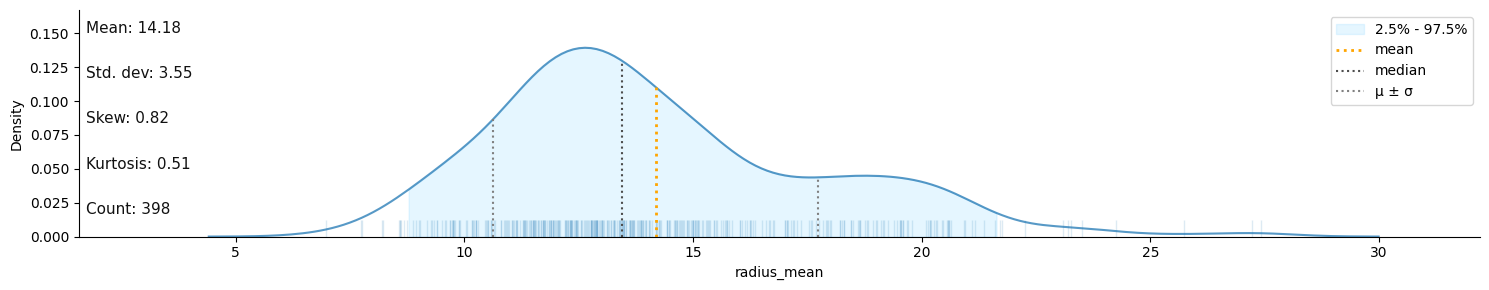

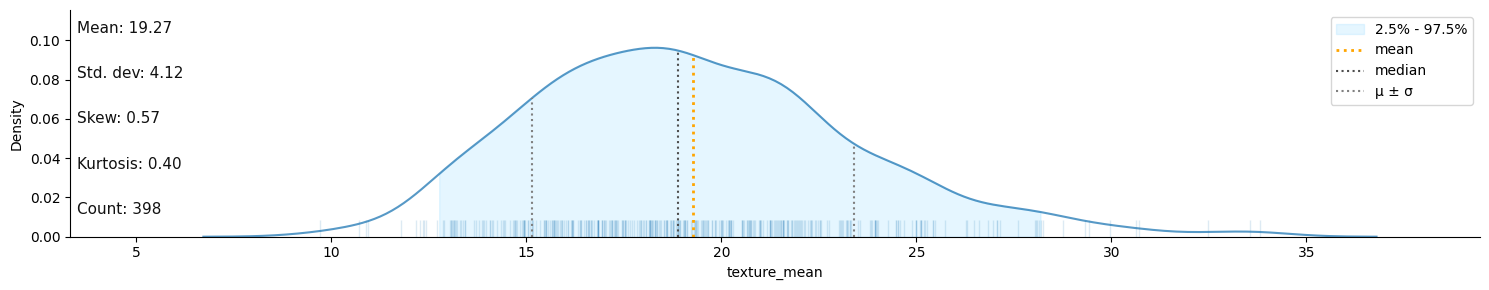

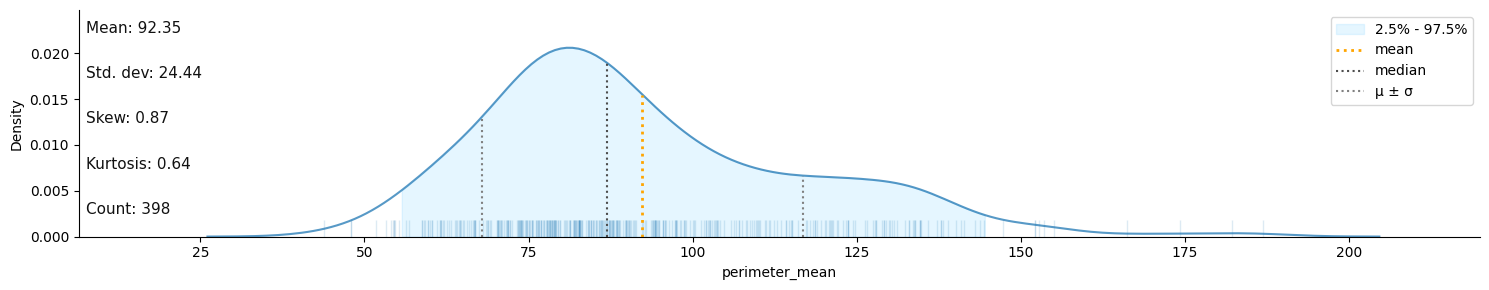

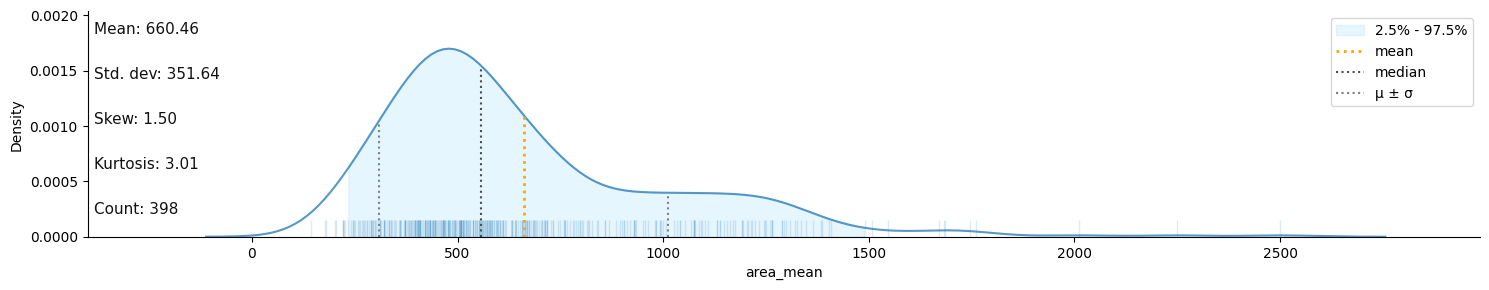

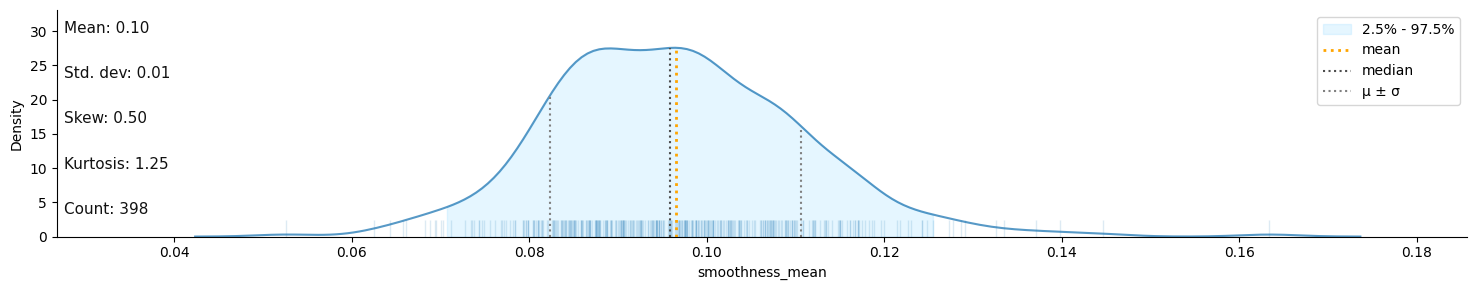

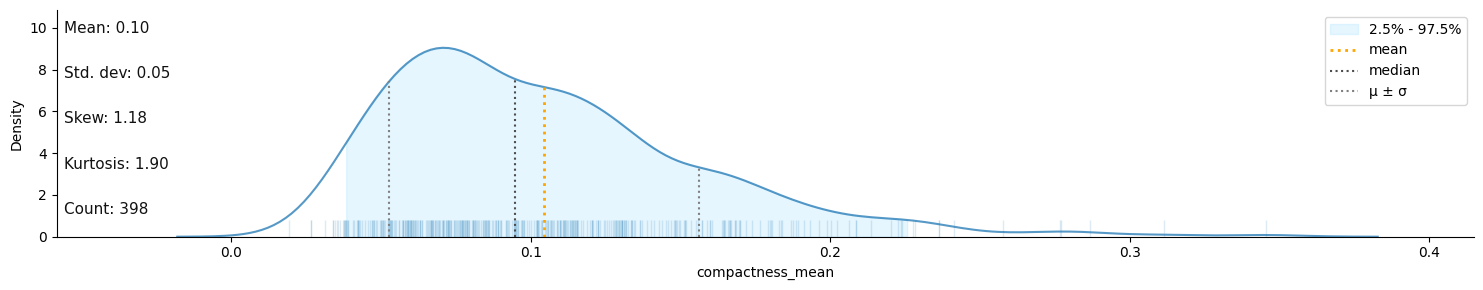

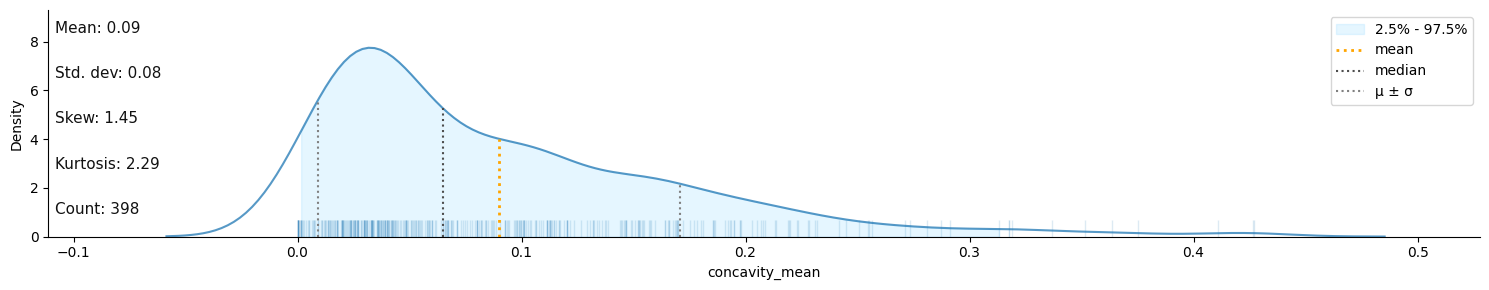

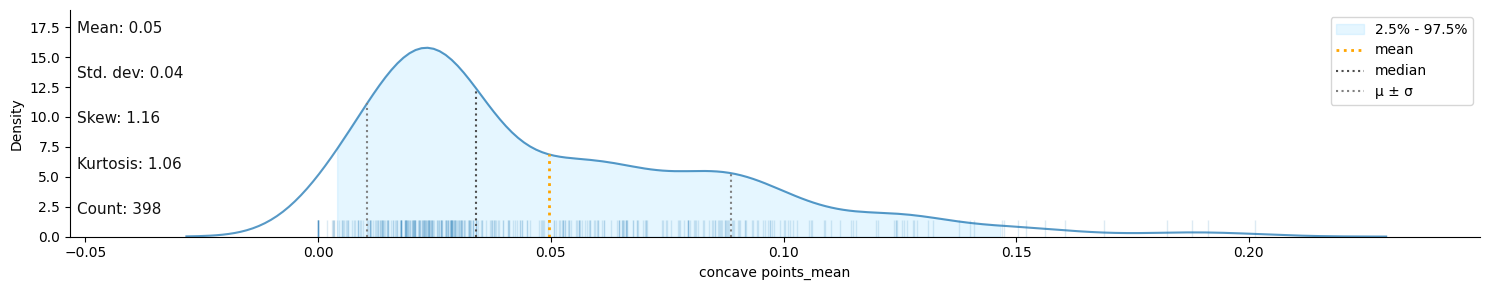

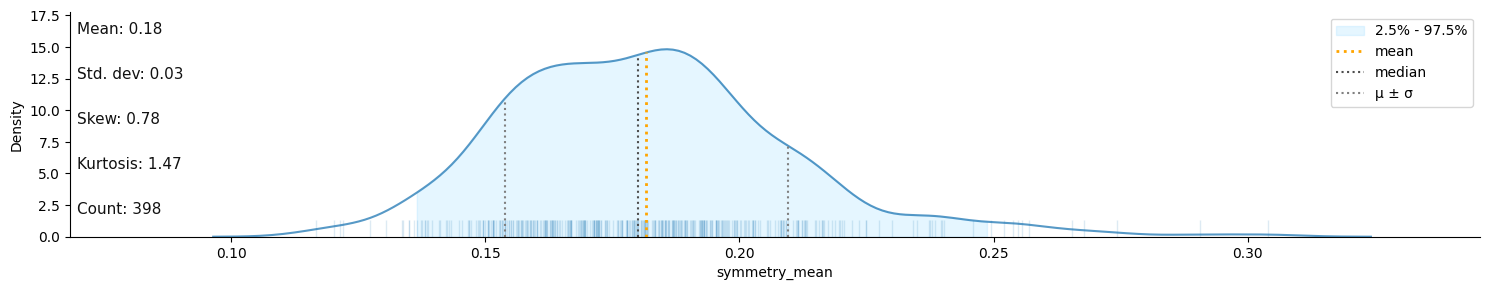

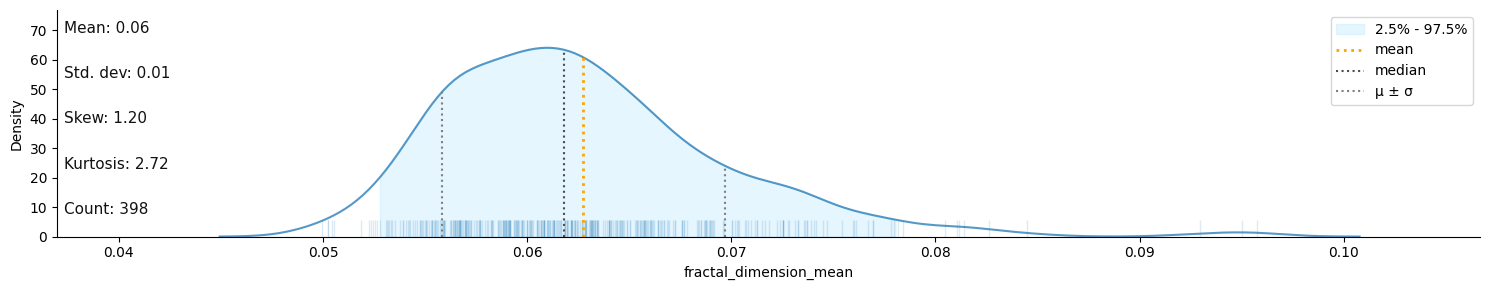

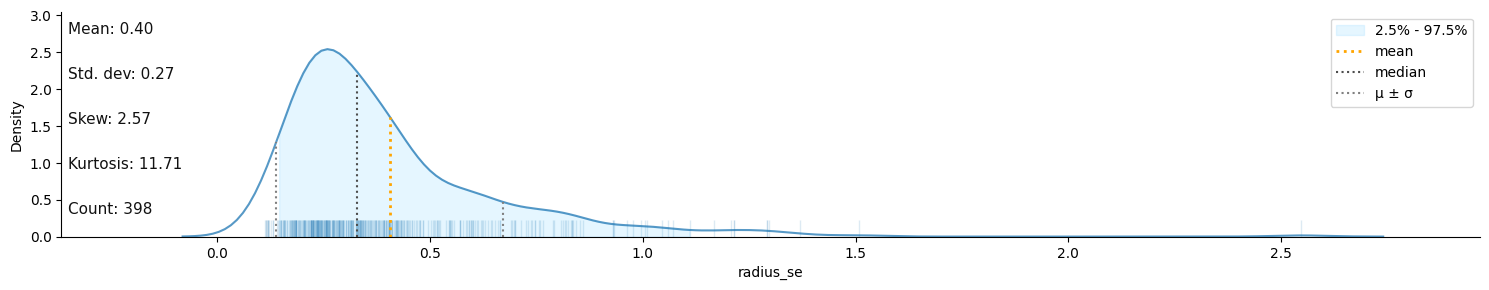

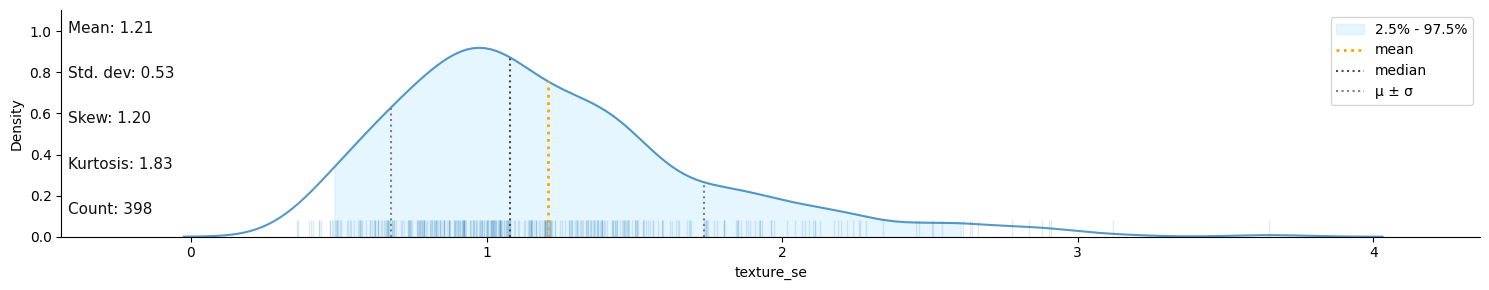

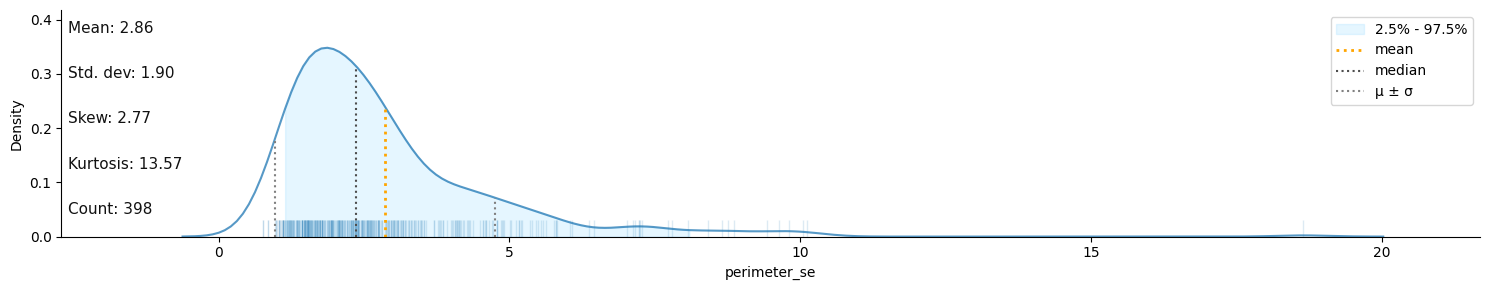

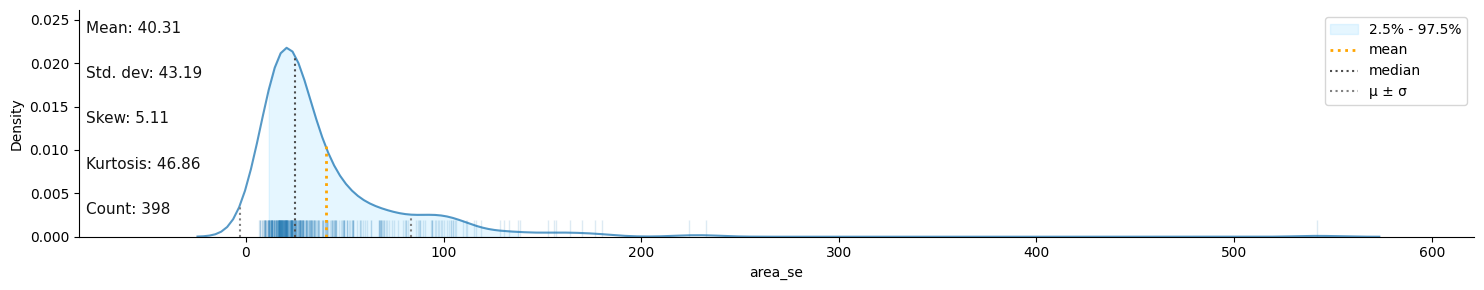

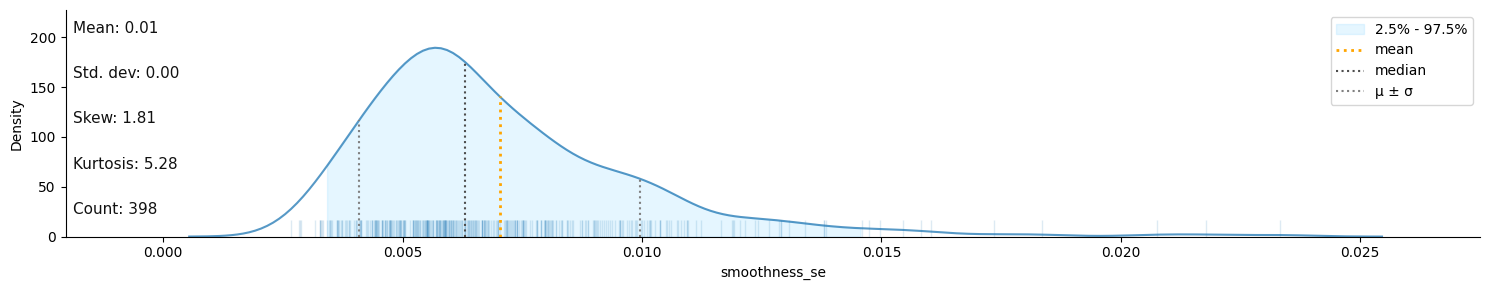

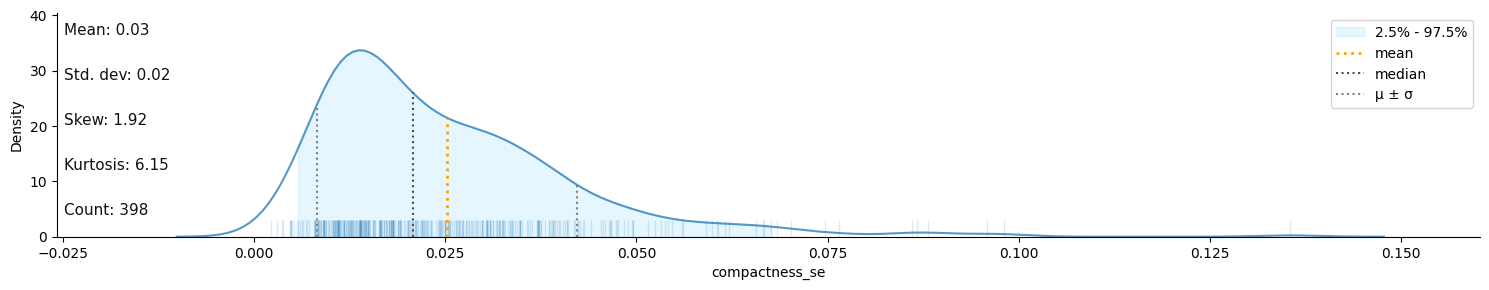

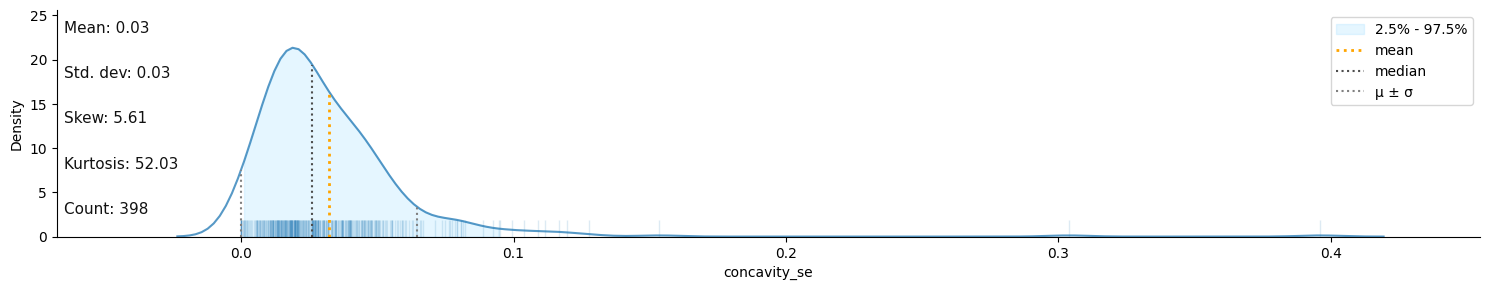

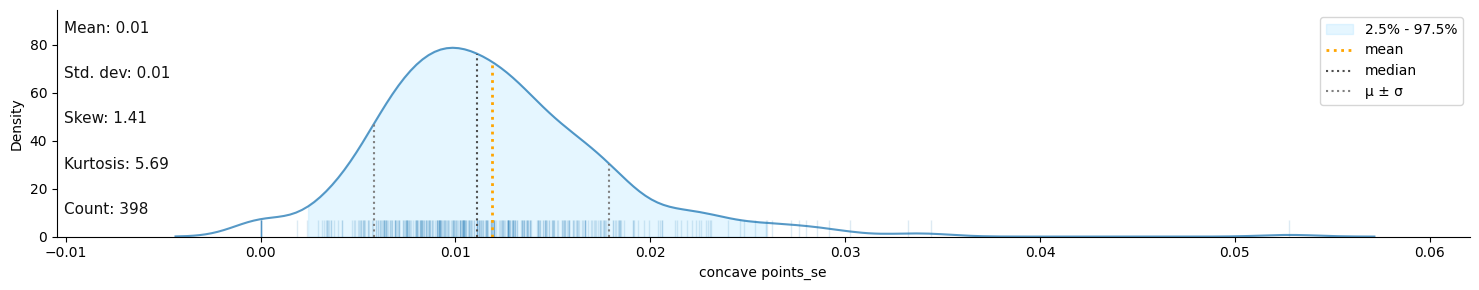

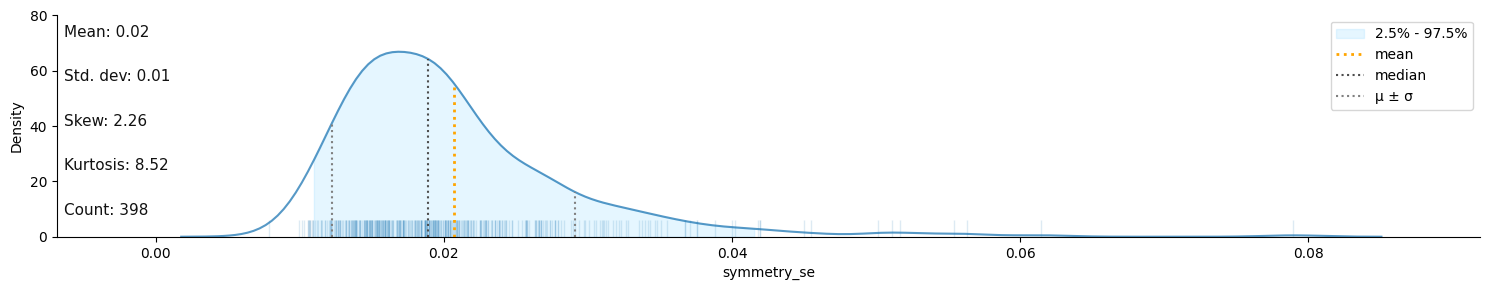

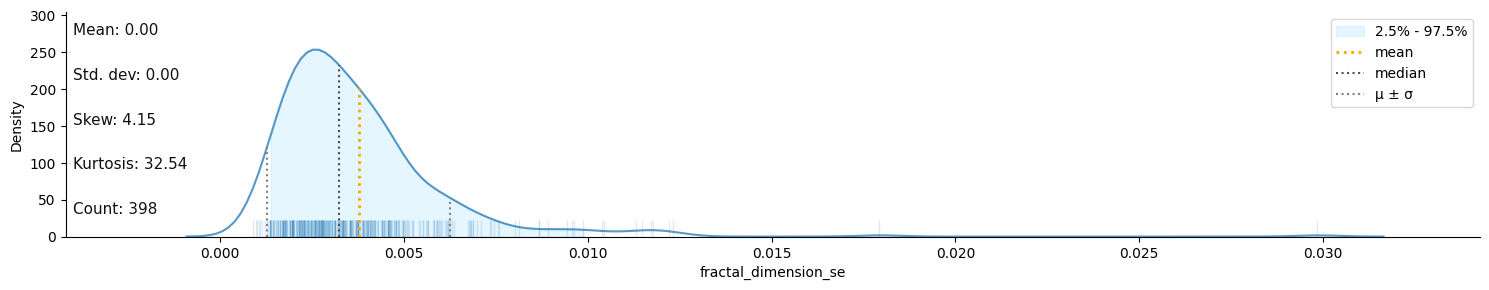

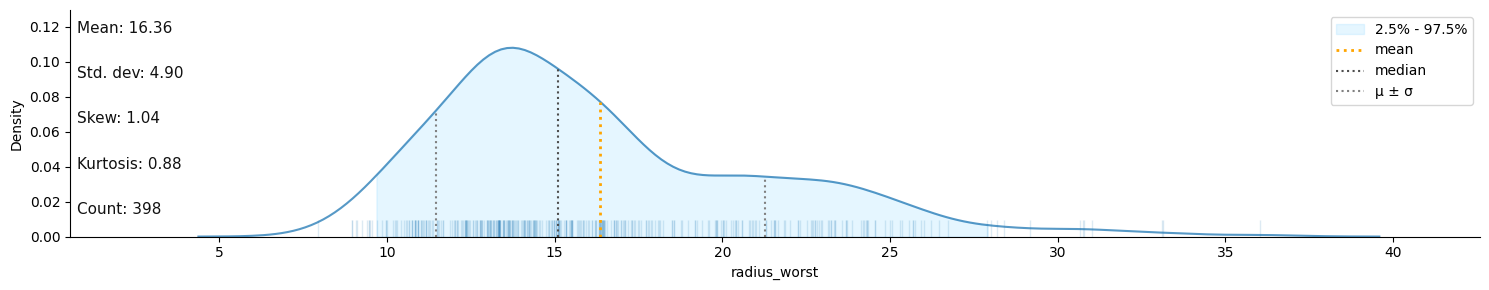

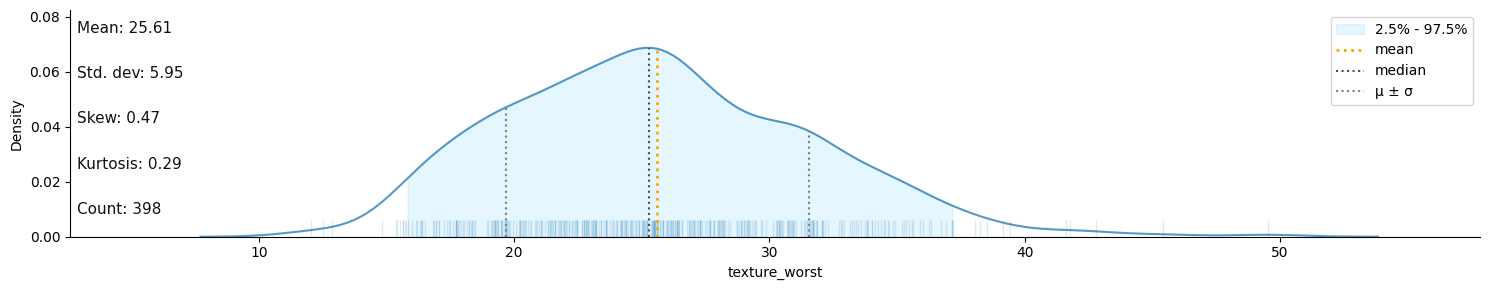

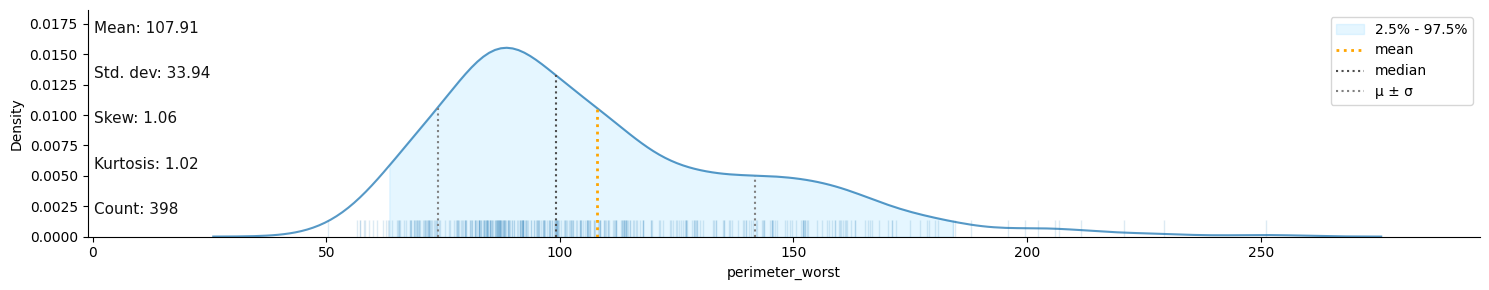

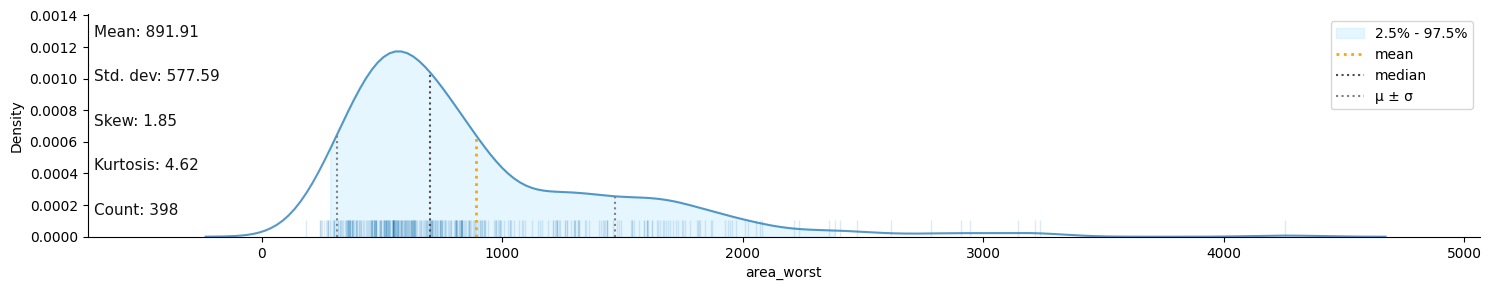

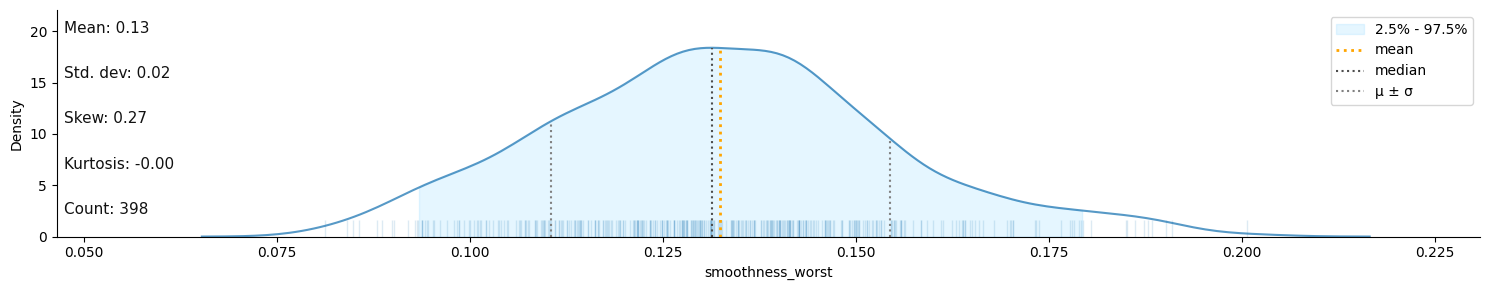

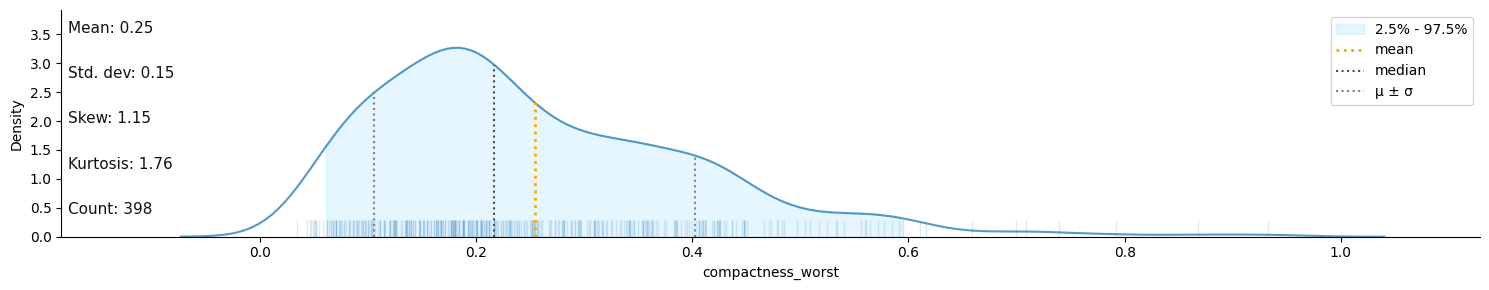

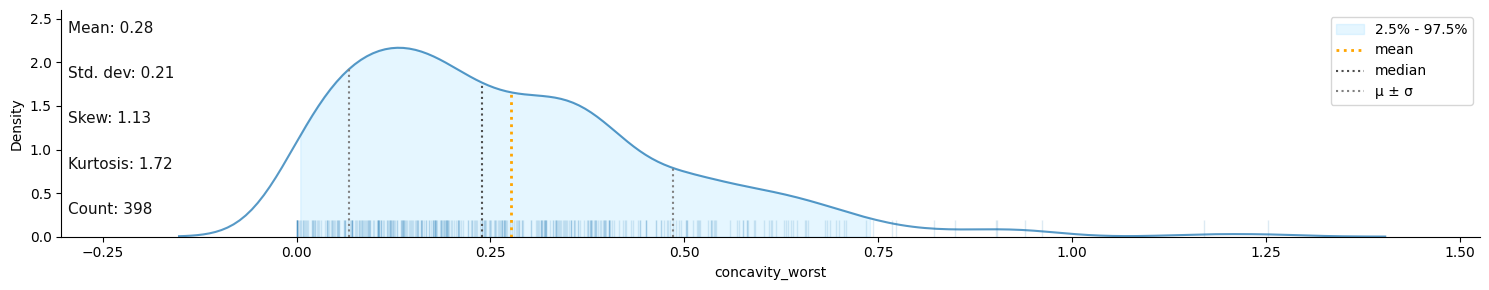

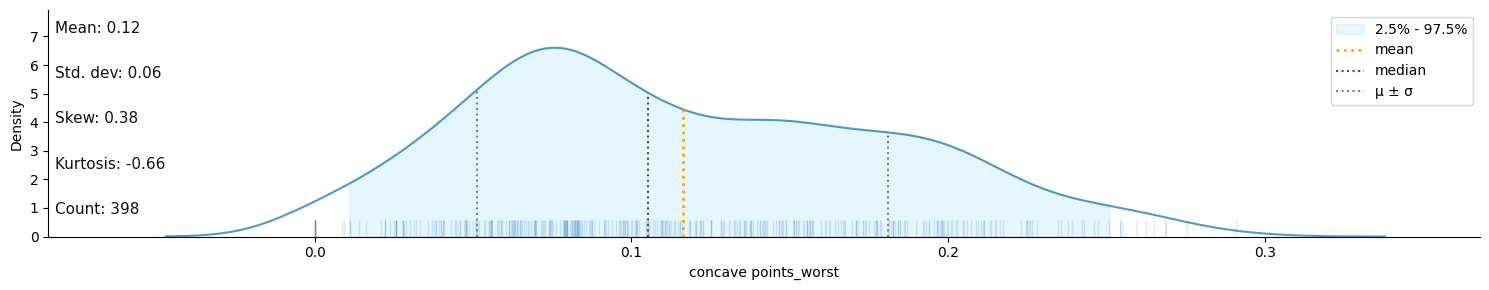

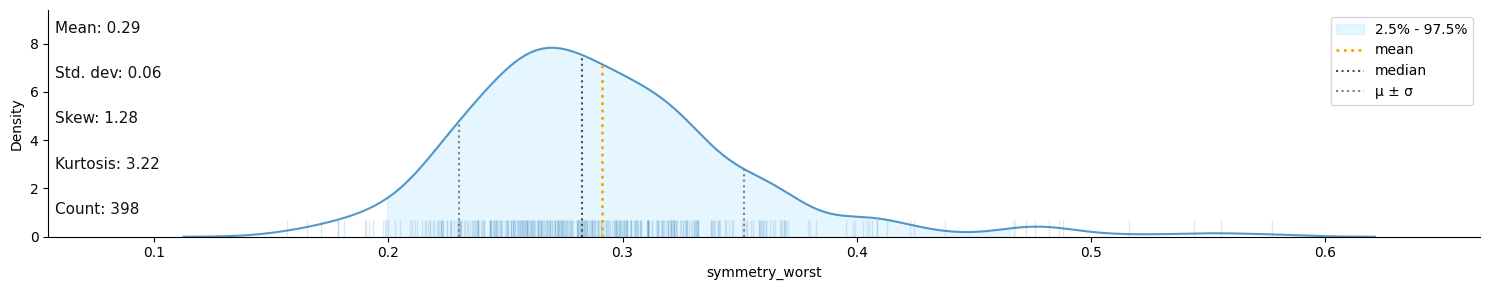

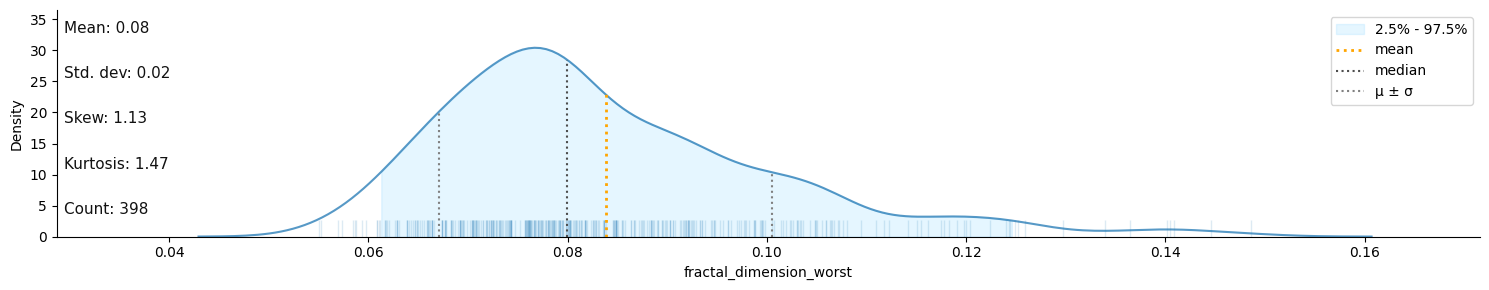

In [14]:
klib.dist_plot(train, showall=True)

# Impressions
So far the data looks good, no major problems aside from removing a low corelation, high missing value feature from the sets. Corelations are high for almost all features, noe that look like they will cause issues. I will continue on without any further cleaning, and see how well the models perform before trying any further manipulation of the datasets. 

# Creating the Traing and Testing Sets.

In [15]:
X = train.drop(columns='diagnosis')
y = np.array(train['diagnosis'] * 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
print (y)

[1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1
 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0
 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0
 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0
 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0
 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1
 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1
 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0]


# Modeling Functions
Here I will take the time to create several functions to iterate through the different hyperparameters and return the most effective models and their respective parameters dictionaries. that will aslo require a function to iterate through maps for the data to return maps as well to corelate the predictions with their actual values. 

In [17]:

def label_permute_compare(yt, yp, num_classes):
    label_map = []
    per_table = list(itertools.permutations(list(range(num_classes))))

    for table in per_table:
        label_map.append(dict(zip(range(num_classes), table)))


    
    best_acc = 0
    best_map = list(range(num_classes))
    best_rmse = 0
    
    for map in label_map:
        yhat = np.array([map[val] for val in yp])
        acc = np.mean(yhat == yt)
        rmse = np.sqrt(((yhat-yt)**2).mean())
        if acc > best_acc:
            best_acc = acc
            best_map = map
            best_rmse = rmse
    print(f'Best Acc: {best_acc}')
    print(f'Best map: {best_map}')
    print(f'Best rmse: {best_rmse}')
    return best_map, best_acc, best_rmse, yhat

def unSuperModelSearch(X_train, X_test, y_train, y_test, n_components, n_clusters):
    dimensional_redux = {'None': None, 'PCA': PCA(n_components=n_components, random_state=42), 'NMF': NMF(n_components=n_components, init='random', random_state=42, max_iter=1000) }

    results = []

    for dim_red_name, dim_red_method in dimensional_redux.items():
        if dim_red_method is not None:
            X_train_redux = dim_red_method.fit_transform(X_train)
            X_test_redux = dim_red_method.fit_transform(X_test)
        else:
            X_train_redux = X_train
            X_test_redux = X_test
        
        km = KMeans(n_clusters=n_clusters, random_state=42)
        km_train_hat = km.fit_predict(X_train_redux)
        km_train_map, km_train_acc, km_train_rmse, km_train_mapped = label_permute_compare(y_train, km_train_hat, n_clusters)
        km_test_hat = km.predict(X_test_redux)
        km_test_map, km_test_acc, km_test_rmse, km_test_mapped = label_permute_compare(y_test, km_test_hat, n_clusters)
        km_f1 = f1_score(y_test, km_test_mapped, average='weighted')
        km_mse = mean_squared_error(y_test, km_test_mapped)

        ag = AgglomerativeClustering(n_clusters=n_clusters)
        ag_train_hat = ag.fit_predict(X_train_redux)
        ag_train_map, ag_train_acc, ag_train_rmse, ag_train_mapped = label_permute_compare(y_train, ag_train_hat, n_clusters)
        ag_test_hat = ag.fit_predict(X_test_redux)
        ag_test_map, ag_test_acc, ag_test_rmse, ag_test_mapped = label_permute_compare(y_test, ag_test_hat, n_clusters)
        ag_f1 = f1_score(y_test, ag_test_mapped, average='weighted')
        ag_mse = mean_squared_error(y_test, ag_test_mapped)


        nmf = NMF(n_components=n_clusters)
        nmf_train_transform = nmf.fit_transform(X_train)
        nmf_train_hat = np.argmax(nmf_train_transform, axis=1)
        nmf_train_map, nmf_train_acc, nmf_train_rmse, nmf_train_mapped = label_permute_compare(y_train, nmf_train_hat, n_clusters)
        nmf_test_transform = nmf.fit_transform(X_test)
        nmf_test_hat = np.argmax(nmf_test_transform, axis=1)
        nmf_test_map, nmf_test_acc, nmf_test_rmse, nmf_train_mapped = label_permute_compare(y_test, nmf_test_hat, n_clusters)
        nmf_f1 = f1_score(y_test, nmf_test_hat, average='weighted')
        nmf_mse = mean_squared_error(y_test, nmf_test_hat)

        
        results.append({
            'Model': f'KMeans(dr: {dim_red_name})',
            'Accuracy': km_test_acc,
            'F1': km_f1,
            'Map': km_test_map,
            })
        results.append({
            'Model': f'Aglomerative Clustering(dr: {dim_red_name})',
            'Accuracy': ag_test_acc,
            'F1': ag_f1,
            'Map': ag_test_map,            
            })
        results.append({ 
            'Model': f'NMF(dr: {dim_red_name})',
            'Accuracy': nmf_test_acc,
            'F1': nmf_f1,
            'Map': nmf_test_map,
            })

            
    return pd.DataFrame(results)

# Model Training and Tuning
Building and testing all of the models we will be using and returning a datfram with their scores, parameters and maps. 

In [18]:
un_super_results = unSuperModelSearch(X_train, X_test, y_train, y_test, n_components=10, n_clusters=2)
display(un_super_results)

Best Acc: 0.8427672955974843
Best map: {0: 1, 1: 0}
Best rmse: 0.3965257928590721
Best Acc: 0.85
Best map: {0: 1, 1: 0}
Best rmse: 0.3872983346207417
Best Acc: 0.8553459119496856
Best map: {0: 1, 1: 0}
Best rmse: 0.38033417944002146
Best Acc: 0.8875
Best map: {0: 1, 1: 0}
Best rmse: 0.33541019662496846
Best Acc: 0.6886792452830188
Best map: {0: 0, 1: 1}
Best rmse: 0.5579612484008016
Best Acc: 0.75
Best map: {0: 0, 1: 1}
Best rmse: 0.5
Best Acc: 0.8427672955974843
Best map: {0: 1, 1: 0}
Best rmse: 0.3965257928590721
Best Acc: 0.85
Best map: {0: 1, 1: 0}
Best rmse: 0.3872983346207417
Best Acc: 0.8553459119496856
Best map: {0: 1, 1: 0}
Best rmse: 0.38033417944002146
Best Acc: 0.8875
Best map: {0: 1, 1: 0}
Best rmse: 0.33541019662496846
Best Acc: 0.6886792452830188
Best map: {0: 0, 1: 1}
Best rmse: 0.5579612484008016
Best Acc: 0.75
Best map: {0: 0, 1: 1}
Best rmse: 0.5
Best Acc: 0.8238993710691824
Best map: {0: 0, 1: 1}
Best rmse: 0.41964345453112645
Best Acc: 0.8125
Best map: {0: 0, 1: 1}

,Model,Accuracy,F1,Map
0,KMeans(dr: None),0.8500,0.842582,"{0: 1, 1: 0}"
1,Aglomerative Clustering(dr: None),0.8875,0.883932,"{0: 1, 1: 0}"
2,NMF(dr: None),0.7500,0.720238,"{0: 0, 1: 1}"
3,KMeans(dr: PCA),0.8500,0.842582,"{0: 1, 1: 0}"
4,Aglomerative Clustering(dr: PCA),0.8875,0.883932,"{0: 1, 1: 0}"
5,NMF(dr: PCA),0.7500,0.720238,"{0: 0, 1: 1}"
6,KMeans(dr: NMF),0.8125,0.134211,"{0: 0, 1: 1}"
7,Aglomerative Clustering(dr: NMF),0.8875,0.883932,"{0: 1, 1: 0}"
8,NMF(dr: NMF),0.7500,0.720238,"{0: 0, 1: 1}"


# Comparisons to Supervised Couterparts
Here we will do essentailly the same thing for the supervised models so that we can get a comparison to the performance of supervised models. 

In [19]:
def superModelSearch(X_train, X_test, y_train, y_test): 
        model_grid = {'LogisticRegression':{'model': LogisticRegression(), 'parameters':{'C': [0.0001,0.001,0.01,0.1,1,10,100], 'penalty':['l1', 'l2']}, 'max_iter':[2000]},
                    'KNeighborsClassifier':{'model': KNeighborsClassifier(), 'parameters':{'n_neighbors':[2,3,4,5,6,7,8,9,10], 'weights':['uniform', 'distance']}},
                    'RandomForestClassifier':{'model': RandomForestClassifier(), 'parameters':{'n_estimators': [50, 100, 200],'max_depth': [None, 5, 10],'min_samples_split': [2, 5, 10]}}, 
                    'SVC':{'model': SVC(), 'parameters':{'C': [0.1, 1, 10],'kernel': ['rbf'],'gamma': ['scale', 'auto']}}
                    }
        
        results = []

        for model_name, parameters in model_grid.items():
                grid = GridSearchCV(estimator=parameters['model'], param_grid=parameters['parameters'], scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                y_hat = best_model.predict(X_test)
                acc = accuracy_score(y_test, y_hat)
                mse = mean_squared_error(y_test, y_hat)
                rmse = np.sqrt(mse)
                f1 = f1_score(y_test, y_hat, average='weighted')
                cm = confusion_matrix(y_test, y_hat)
                results.append({'Model': model_name, 'Best_Paramaters': grid.best_params_, 'Accuracy': acc, 'F1': f1, 'RMSE': rmse, 'Confusion_Matrix': cm})

        return pd.DataFrame(results)


In [20]:
ss = preprocessing.StandardScaler()
X_train_n = ss.fit_transform(X_train)
X_test_n = ss.fit_transform(X_test)
super_results = superModelSearch(X_train_n, X_test_n, y_train, y_test)
display(super_results)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Best_Paramaters,Accuracy,F1,RMSE,Confusion_Matrix
0,LogisticRegression,"{'C': 1, 'penalty': 'l2'}",0.9875,0.987474,0.111803,"[[46, 0], [1, 33]]"
1,KNeighborsClassifier,"{'n_neighbors': 7, 'weights': 'uniform'}",0.9750,0.974887,0.158114,"[[46, 0], [2, 32]]"
2,RandomForestClassifier,"{'max_depth': None, 'min_samples_split': 10, '...",0.9625,0.962227,0.193649,"[[46, 0], [3, 31]]"
3,SVC,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.9875,0.987474,0.111803,"[[46, 0], [1, 33]]"


# Pre-Processing Trials.

In [21]:
#X_train_n = preprocessing.normalize(X_train)
#X_test_n = preprocessing.normalize(X_test)

In [22]:
#ss = preprocessing.StandardScaler()
#X_train_n = ss.fit_transform(X_train)
#X_test_n = ss.fit_transform(X_test)

# Testing a Model That Showed 100% Accuracy
On one of the runs, the logistic regression model showed 100% accuracy. Its cross val score showed two in the 98% range, and 3 at 100%. 

In [23]:
lr = LogisticRegression(C=1, penalty='l2')
lr.fit(X_train_n, y_train)
print(cross_val_score(lr, X_test_n, y_test))

[1.     0.9375 1.     0.9375 1.    ]


# Comparison
Here we can clearly seee the results of the test. The supervised models were superior as far as accuracy goes, and if labels are avaialbe, then this would be the prefered method I think. Supprisingly, the AG clustering was nearly as accurate as the supervised models. Though after submitting the results to the competion and getting back 90% I suspect a small amount of overfitting. In any future iterations I will use the mean of the cross val scores to score my models.    

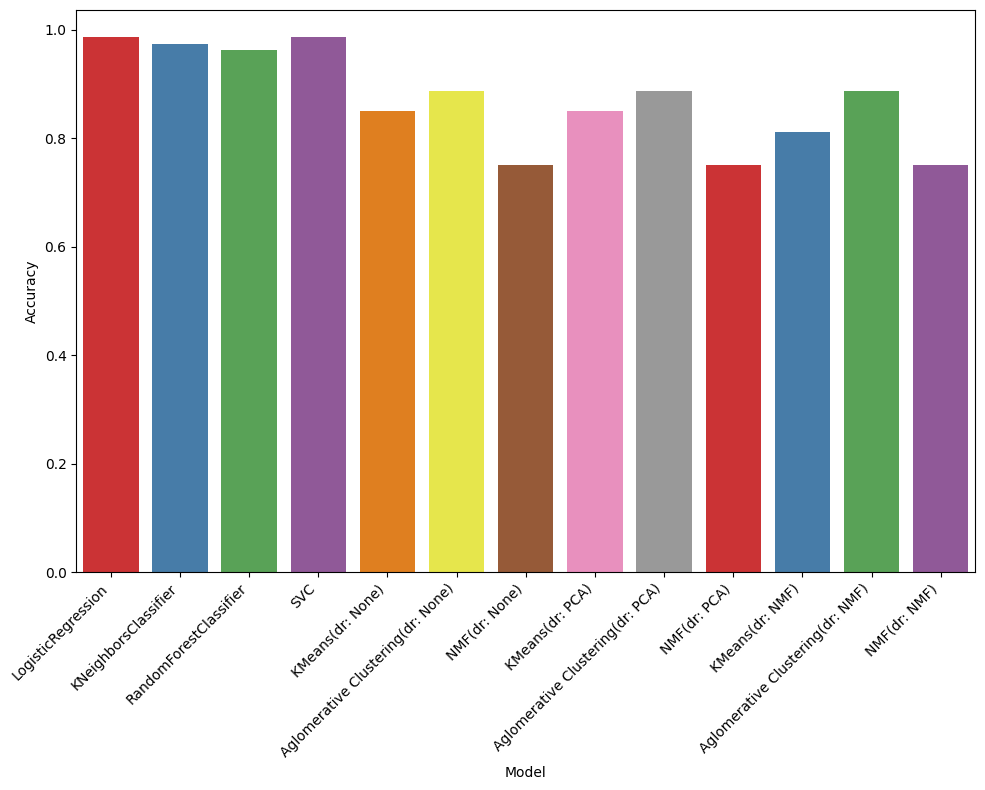

In [24]:
# display the result from both the supervised and unsupervised models with scores
super_results['Type'] = 'Supervised'
un_super_results['Type'] = 'Unsupervised'

complete_results = pd.concat([super_results[['Model', 'Accuracy']], un_super_results], ignore_index=True)
plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='Accuracy', data=complete_results, palette='Set1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [25]:
def submit(data):
    clean_test = data
    X_test_redux = NMF(n_components=3, init='random', random_state=42, max_iter=10000).fit_transform(clean_test)
    ag = AgglomerativeClustering(n_clusters=2)
    ag_test_hat = ag.fit_predict(X_test_redux)
    map = {1:'B', 0:'M'}
    submission_predictions = [map[val] for val in ag_test_hat]
    sample['diagnosis'] = submission_predictions
    return sample

In [26]:
sample = submit(test)
sample.to_csv('/kaggle/working/submission.csv', index=False)